# 1 Author

**Student Name**:  Yuxiang Tu

**Student ID**:  2023213037

# 2 Problem formulation

本项目的核心目标是构建一个机器学习模型，解决一个极具挑战性的音频分类问题：根据一段时长为 15 -20 秒的哼唱 (Hum) 或口哨 (Whistle) 录音，预测其对应的歌曲名称 (Song Title)。

具体而言，这是一个多分类监督学习任务 (Multi-class Supervised Learning Task)。

输入：来自 MLEnd Hums and Whistles II 数据集的音频片段。这些音频由不同参与者录制，包含两种截然不同的演绎方式（哼唱与口哨）。

输出：模型需要从预定义的歌曲类别中，识别出该录音所属的正确歌曲标签。

这一任务的复杂性与挑战性主要体现在以下三个方面：

- 非受控环境下的噪声干扰 (Uncontrolled Environmental Noise)： 数据是由数百名不同的学生在各自非标准化的环境中录制的。这意味着录音背景极其复杂且不可预测，可能包含室外风声、电流底噪、甚至其他人声的干扰。这种信噪比 (SNR) 的巨大差异，要求模型不能仅仅依赖干净的信号特征，而必须具备极强的抗噪能力，从嘈杂背景中分离出有效信号。

- 跨模态的特征提取难点 (Cross-modal Feature Extraction)： 数据集混合了“哼唱”和“口哨”两种截然不同的发声方式。在信号处理层面，口哨接近纯音（正弦波），能量集中在基频；而哼唱则包含基频和丰富的泛音结构。简单的时域波形或单一的频域特征往往难以同时有效表征这两种模式。这迫使我们的特征工程策略必须跳出“音色”的局限，转而聚焦于能够统一这两种模态的**“旋律结构” (Melody Structure)**。

- 极高的类内差异与鲁棒性要求 (High Intra-class Variability)： 即便是同一首歌，不同参与者的演绎也千差万别。首先，音色 (Timbre) 因人而异（如男低音与女高音的频谱差异）；其次，作为非专业歌手，样本中普遍存在跑调 (Off-key)、节奏不稳甚至断断续续的现象。模型必须具备极高的鲁棒性，能够“忽略”绝对音高和音色的干扰，从不完美的演绎中提取出潜在的旋律指纹，才能实现准确分类。

# 3 Methodology

本实验采用 **监督学习 (Supervised Learning)** 范式，旨在构建一个能够处理非结构化音频数据的深度学习分类系统。我们的核心方法论聚焦于解决数据集的小样本特性（Small Sample Size）与高类内变异（High Intra-class Variability）之间的矛盾，通过严谨的数据划分、激进的数据增强以及集成式推理策略来提升模型的泛化能力。

## 3.1 Data Partitioning Strategy (数据划分策略)

为了在有限的数据规模（800样本）下平衡模型训练的充分性与性能评估的无偏性（Unbiased Evaluation），我们摒弃了简单的单次留出法（Simple Hold-out），转而采用了更为严谨的 **“独立测试集 + 4折交叉验证”** 混合策略。

整体数据划分为 **60% 训练 / 20% 验证 / 20% 测试**。具体逻辑如下：

1.  **独立测试集 (Independent Test Set, 20%)**：
    * 首先，我们利用分层抽样（Stratified Sampling）从原始数据集中分离出 **20%** 的样本作为测试集。这样能保证数据之间的独立性，同时选取对于每一个类别的歌曲选取10个哼唱，10个口哨作为数据集。
    * **关键原则**：这部分数据被严格隔离（Data Isolation），**仅**在所有模型开发、超参数调优结束后，用于最终的性能报告。这避免了“数据窥探偏差” (Data Snooping Bias)，确保评估结果能真实反映模型在未见数据上的表现。

2.  **4折交叉验证 (4-Fold Cross-Validation, 80%)**：
    * 针对剩余 **80%** 的开发数据集，我们实施了 **4折交叉验证**。
    * 在每一轮验证中，开发数据的 $\frac{1}{4}$（即总量的 **20%**）被用作验证集 (Validation Set) 用于监控训练过程和早停机制 (Early Stopping)，而剩余的 $\frac{3}{4}$（即总量的 **60%**）被用作训练集 (Training Set)。
    * **选择理由**：这种设置实现了 **60% 训练 / 20% 验证** 的比例分配。相较于更细粒度的切分（如 10% 验证），20% 的验证集规模能提供更稳定的性能反馈，减少因验证集过小导致的 Loss 震荡。同时，交叉验证通过多次轮转评估，最大限度地减少了因单次数据划分偶然性带来的评估误差，从而降低了评估结果的方差（Variance）。

## 3.2 Training Task & Enhancement (训练任务与增强)

训练任务的核心目标是学习一个从音频特征空间到歌曲标签空间的映射函数 $f: X \rightarrow Y$。为了提高模型在复杂声学环境下的鲁棒性，我们引入了以下关键策略：

* **数据增强 (Data Augmentation)**：针对训练集实施了激进的增强策略，特别是 **音高偏移 (Pitch Shifting)**（$\pm 1, \pm 2$ 半音）和 **高斯噪声注入**。这不仅将训练样本规模扩充了 5-6 倍，更迫使模型学习对绝对音高和环境噪声不敏感的“相对旋律特征”。
* **早停机制 (Early Stopping)**：为了防止深度网络在小数据集上过拟合，我们监控验证集上的 Accuracy。当验证性能在连续 $N$ 个 Epoch 内未提升时，自动终止训练并回滚至最佳权重。

## 3.3 Performance Evaluation Metrics (性能评估指标)

根据多分类任务的评估标准，我们采用多维度的指标体系：

1.  **准确率 (Accuracy)**：作为主要指标，衡量全局的分类正确率。
2.  **混淆矩阵 (Confusion Matrix)**：鉴于音频分类中可能存在特定歌曲间的混淆（如旋律相似），我们将通过混淆矩阵分析 **假阳性 (False Positives)** 和 **假阴性 (False Negatives)** 的分布，诊断模型的具体错误模式。
3.  **F1-Score (Macro & Weighted)**：
    * **Macro-average F1**：对所有类别的 F1 分数取算术平均，平等对待每一首歌曲。
    * **Weighted-average F1**：按各类别的样本数量加权。
    * **对比分析**：通过对比这两个指标，我们可以判断模型是否在样本较少的“冷门歌曲”上依然保持了良好的识别能力，从而评估模型对类别不平衡（Class Imbalance）的敏感度。

## 3.4 Inference Strategy for Long Audio (长音频推理策略)

针对测试任务中可能出现的长音频（15-20s），我们设计了 **“滑动窗口软投票” (Sliding Window Soft Voting)** 机制。

* **策略**：模型不再对整段音频直接分类，而是将其切分为多个重叠的 5s 片段，分别预测概率分布，最后取均值作为最终判决。
* **优势**：这种集成思想（Ensemble-like strategy）利用了时域上的冗余信息，能够有效平滑掉局部噪声或无声片段带来的预测波动，进一步提升了预测的稳定性。

# 4 Implemented ML prediction pipelines

在本节中，我们将详细阐述端到端的机器学习预测流水线（End-to-End Prediction Pipeline）。该流水线旨在将非结构化、变长的原始音频信号转化为结构化的歌曲标签预测。

为了应对数据集中存在的**高类内变异（跑调、音色差异）**以及**输入时长不统一（5s - 20s）**的问题，我们设计了一个包含数据增强、双流特征提取和集成推理的复合架构。

### 4.0 Pipeline Overview (流水线概览)

整体处理流程可以划分为以下五个核心阶段。下图展示了数据在各个阶段的流向与维度变化：

1.  **输入与重采样 (Input & Resampling)**:
    * 原始 `.wav` 文件统一重采样至 **22050 Hz**，确保频域特征的一致性。
2.  **分段与增强 (Segmentation & Augmentation)**:
    * **切片 (Slicing)**: 采用滑动窗口策略（窗口大小 5s，步长 4s），将不定长音频转化为固定的 $N \times 5s$ 片段。对于不足 5s 的部分进行 Padding 或回溯截取。
    * **增强 (Augmentation)**: *仅针对训练集*，应用 **音高偏移 (Pitch Shifting)** ($\pm 1, \pm 2$ 半音) 和 **噪声注入 (Noise Injection)**，以扩充样本多样性并提高抗噪能力。
3.  **特征变换 (Transformation)**:
    * 构建双流特征输入：
        * **Stream A**: Log-Mel Spectrogram $(128, 216)$ —— 捕捉音色与纹理。
        * **Stream B**: Chroma Feature $(12, 216)$ —— 捕捉旋律与和声结构。
4.  **深度模型 (Dual-Stream Modeling)**:
    * 输入双流特征至 **Dual-Stream CNN**。网络包含两个独立的卷积分支用于提取异构特征，随后通过特征融合层（Concatenation）和全连接层输出分类概率。
5.  **推理与聚合 (Inference & Aggregation)**:
    * 在测试阶段，针对单个长音频生成的多个切片预测结果，采用 **滑动窗口软投票 (Sliding Window Soft Voting)** 机制，计算平均概率向量以得出最终标签。

### 4.0.1 数据准备阶段：
下载数据集并进行划分，60%训练集，20%验证集，20%测试集

## 4.1 Transformation stage

在此阶段，我们将原始的一维音频波形转换为适合卷积神经网络处理的二维时频图表示。为了确保评估的严谨性，特别是在交叉验证框架下，我们的转换模块被设计为**动态流水线 (Dynamic Pipeline)**，能够根据数据划分（训练/验证）自适应地应用数据增强策略。

### 4.1.1 Audio Preprocessing (音频预处理)

在提取特征之前，我们对原始 `.wav` 文件进行了标准化的预处理：
1.  **Resampling (重采样)**: 所有音频统一重采样至 **22050 Hz** (Nyquist frequency $\approx$ 11kHz)，覆盖了人声哼唱和口哨的主要频率范围。
2.  **Sliding Window Slicing (滑动窗口切片)**:
    * 由于输入音频时长不一（5s - 20s），而 CNN 需要固定维度的输入，我们采用了滑动窗口策略。
    * **窗口大小**: 5秒 (110,250 采样点)。
    * **步长**: 4秒 (重叠 1秒)。这不仅增加了样本数量，还保证了长音频中的关键旋律片段不会被截断。
    * 对于不足 5秒的尾部片段，我们采用**回溯填充 (Back-tracking)** 策略，即截取音频的最后 5秒，确保不填充零值（Zero-padding）引入的人为静音干扰。

### 4.1.2 Dual-Stream Feature Extraction (双流特征提取)

我们构建了两种互补的特征图，分别对应模型中的两个输入流：

* **Stream A: Log-Mel Spectrogram (对数梅尔频谱)**
    * **配置**: `n_mels=128`, `n_fft=2048`, `hop_length=512`。
    * **目的**: Log-Mel 频谱模拟了人耳对频率（Mel刻度）和响度（对数刻度）的非线性感知。它保留了完整的频谱包络信息，对于区分 **音色 (Timbre)** 差异（即区分“哼唱”与“口哨”的物理特性）至关重要。
    * **输出维度**: $(128, 216)$。

* **Stream B: Chroma Feature (色度特征)**
    * **配置**: 基于 STFT 能量谱映射至 12 个音级 (Pitch Classes: C, C#, D...)。
    * **目的**: Chroma 特征具有 **“八度不变性” (Octave Invariance)**。无论参与者是男低音还是女高音，只要他们哼唱的是同一段旋律（相对音程关系相同），其 Chroma 图在时间轴上的模式就是高度相似的。这是解决 **高类内变异 (High Intra-class Variability)** 的核心特征。
    * **输出维度**: $(12, 216)$。



### 4.1.3 Dynamic Data Augmentation (动态数据增强)

为了防止模型在小样本（800条）上过拟合，并提高对“跑调”数据的鲁棒性，我们在特征提取阶段集成了在线数据增强。

**关键策略：**
1.  **Pitch Shifting (音高偏移)**: 对训练样本随机进行 $\pm 1$ 和 $\pm 2$ 个半音的移调。这迫使模型忽略绝对音高，专注于学习相对旋律结构。
2.  **Gaussian Noise Injection (噪声注入)**: 叠加 $\sigma=0.005$ 的高斯白噪声，模拟不同的录音环境底噪。

**Integration with Cross-Validation (与交叉验证的集成):**
值得注意的是，为了防止 **数据泄露 (Data Leakage)**，数据增强**仅**应用于当前的训练折 (Training Fold)。在 4折交叉验证的每一轮中，作为验证集的样本（Validation Fold）严格保持原样，不进行任何增强。这种**动态提取机制**确保了我们的评估结果真实反映了模型在真实、未见过的原始数据上的性能。

## 4.3 Ensemble stage

虽然我们没有训练多个异构模型，但在 **推理阶段 (Inference Stage)**，我们引入了基于时域切片的 **“自身集成” (Self-Ensemble)** 策略，以解决测试集中 15-20s 长音频的预测问题。

### 4.3.1 Sliding Window Soft Voting (滑动窗口软投票)
针对不定长的测试音频，我们不进行简单的截断，而是采取以下步骤：
1.  **多视图生成**: 使用滑动窗口（窗口 5s，测试时步长缩短为 2.5s）生成多个重叠切片。
2.  **批量预测**: 将所有切片输入 CNN，获得 $N$ 个概率向量。
3.  **软投票聚合**: 计算概率向量的平均值。这种方法利用了长音频中的冗余信息，能有效平滑掉局部噪声带来的预测波动。

# 5 Dataset

在本节中，我们将详细描述数据集的构建过程，包括数据来源、清洗、标签提取、划分策略以及探索性数据分析（EDA）。我们使用的数据集源自 **MLEnd Hums and Whistles II Dataset** 的 800 样本子集。

## 5.1 Dataset Description (数据集描述)
原始数据集包含 800 个 `.wav` 音频文件，由 MLEnd 社区的参与者录制。每个样本代表一种对特定歌曲的演绎，演绎方式分为“哼唱” (Hum) 和“口哨” (Whistle)。

* **总样本数**: 800
* **音频格式**: WAV
* **采样率**: 原始采样率不一，后续在预处理阶段统一重采样为 **22050 Hz**。
* **标注信息**: 文件名包含了参与者 ID、演绎类型、演绎编号和歌曲名称（例如 `S2_whistle_1_TryEverything.wav`）。

## 5.2 Data Preparation & Cleaning (数据准备与清洗)
为了从非结构化的文件名中提取监督学习所需的标签，我们构建了一个元数据解析流水线：

1.  **Filename Parsing (文件名解析)**: 通过下划线 `_` 分割文件名，提取 `Participant ID`, `Interpretation Type` (Hum/Whistle), 和 `Song Label`。
2.  **Label Normalization (标签标准化)**: 移除文件名后缀，统一歌曲名称格式。
3.  **Stratification Labeling (分层标签构建)**: 为了解决潜在的类别不平衡问题，我们创建了一个组合标签列 `stratify_group`（格式为 `Song_Type`，如 `StarWars_hum`）。这一特征在后续的数据划分中至关重要，它确保了我们能同时对“歌曲类别”和“演绎模态”进行分层抽样。

## 5.3 Splitting Strategy (划分策略)
为了保证评估的严谨性，特别是防止“类别不平衡”和“模态不平衡”（即某些歌的哼唱多、口哨少），我们实施了**定制化的分层划分策略 (Custom Stratified Splitting)**，将数据划分为 **独立测试集** 和 **开发集**：

1.  **Independent Test Set (独立测试集)**:
    * **策略**: 强制从每一首歌曲中，随机抽取 **10个哼唱** 和 **10个口哨** 样本。
    * **规模**: 8 类歌曲 $\times$ 2 种类型 $\times$ 10 个样本 = **160 个样本** (占总量的 20%)。
    * **设计意图**: 构建一个完美的“平衡测试基准” (Perfectly Balanced Benchmark)。无论原始数据分布如何不均，测试集对每一类歌曲和每一种模态的评估权重始终保持一致，从而避免模型因偏向“多数类”而获得虚高的准确率。

2.  **Development Set (开发集)**:
    * **策略**: 剩余的所有数据（约 640 个样本）构成开发集。
    * **用途**: 该集合将在后续实验中用于 **4折交叉验证 (4-Fold Cross-Validation)**，在训练循环中动态划分为训练集和验证集。




✅ 可用于『同一首歌』Hum vs Whistle 对比的样本对：


,song,hum_file,whistle_file,hum_singer,whistle_singer,hum_take,whistle_take
0,Feeling,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S103,S106,1,1
1,Friend,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S113,S106,1,1
2,Happy,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S104,S106,1,1
3,Married,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S104,S101,1,1
4,Necessities,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S107,S100,1,1
5,NewYork,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S109,S101,1,1
6,RememberMe,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S110,S101,1,1
7,TryEverything,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,Data_MLEnd_Song\unzipped\MLEndHWII_sample_800\...,S107,S100,1,1


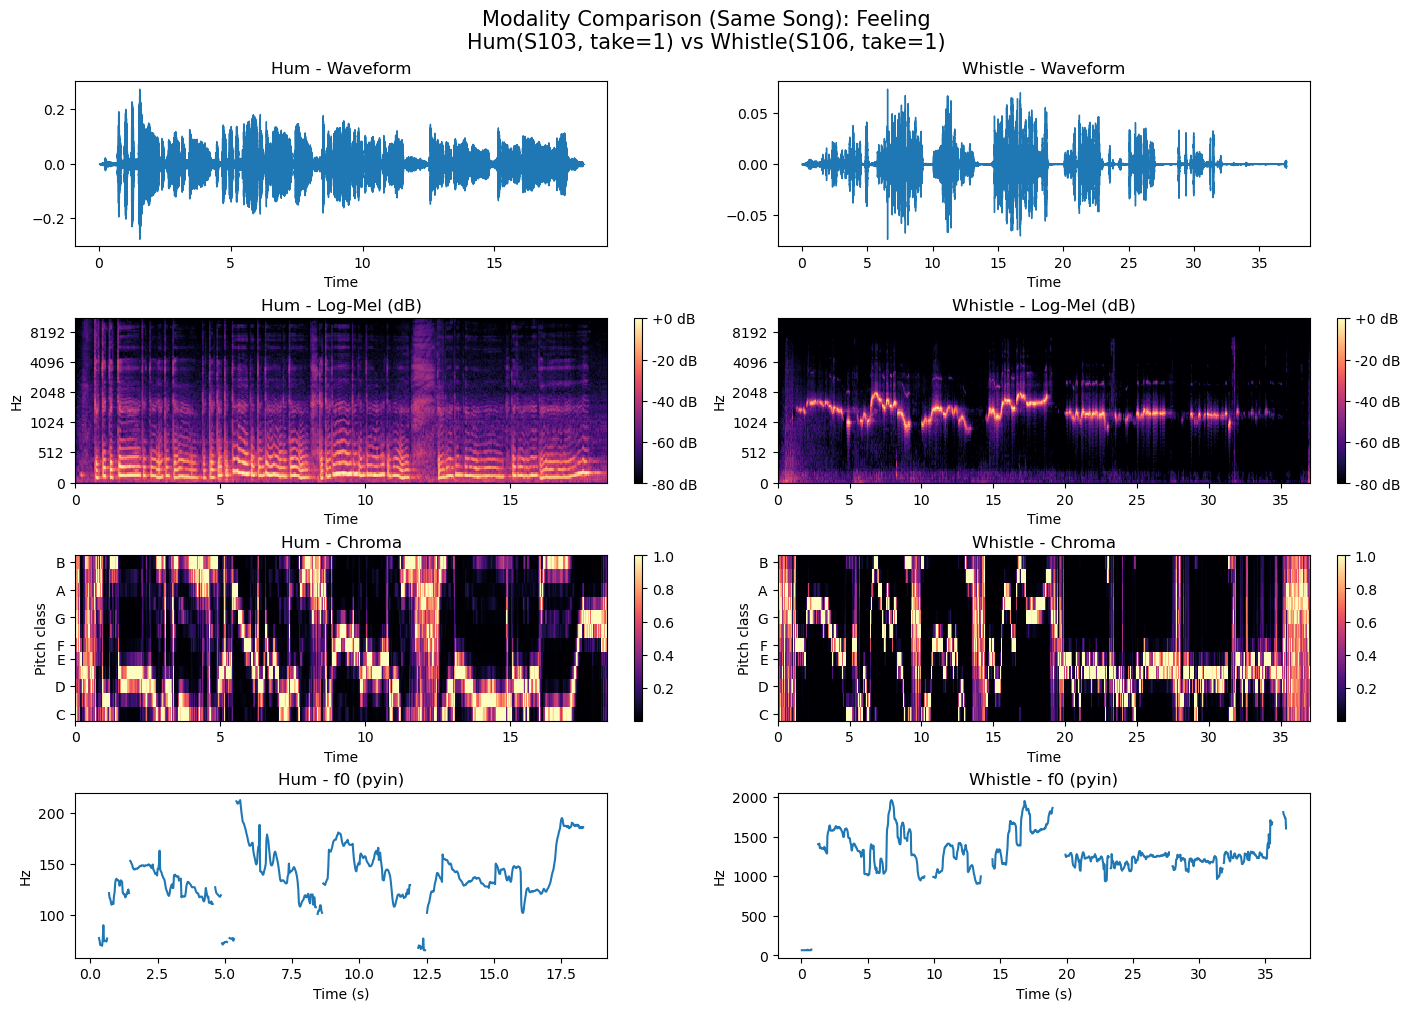

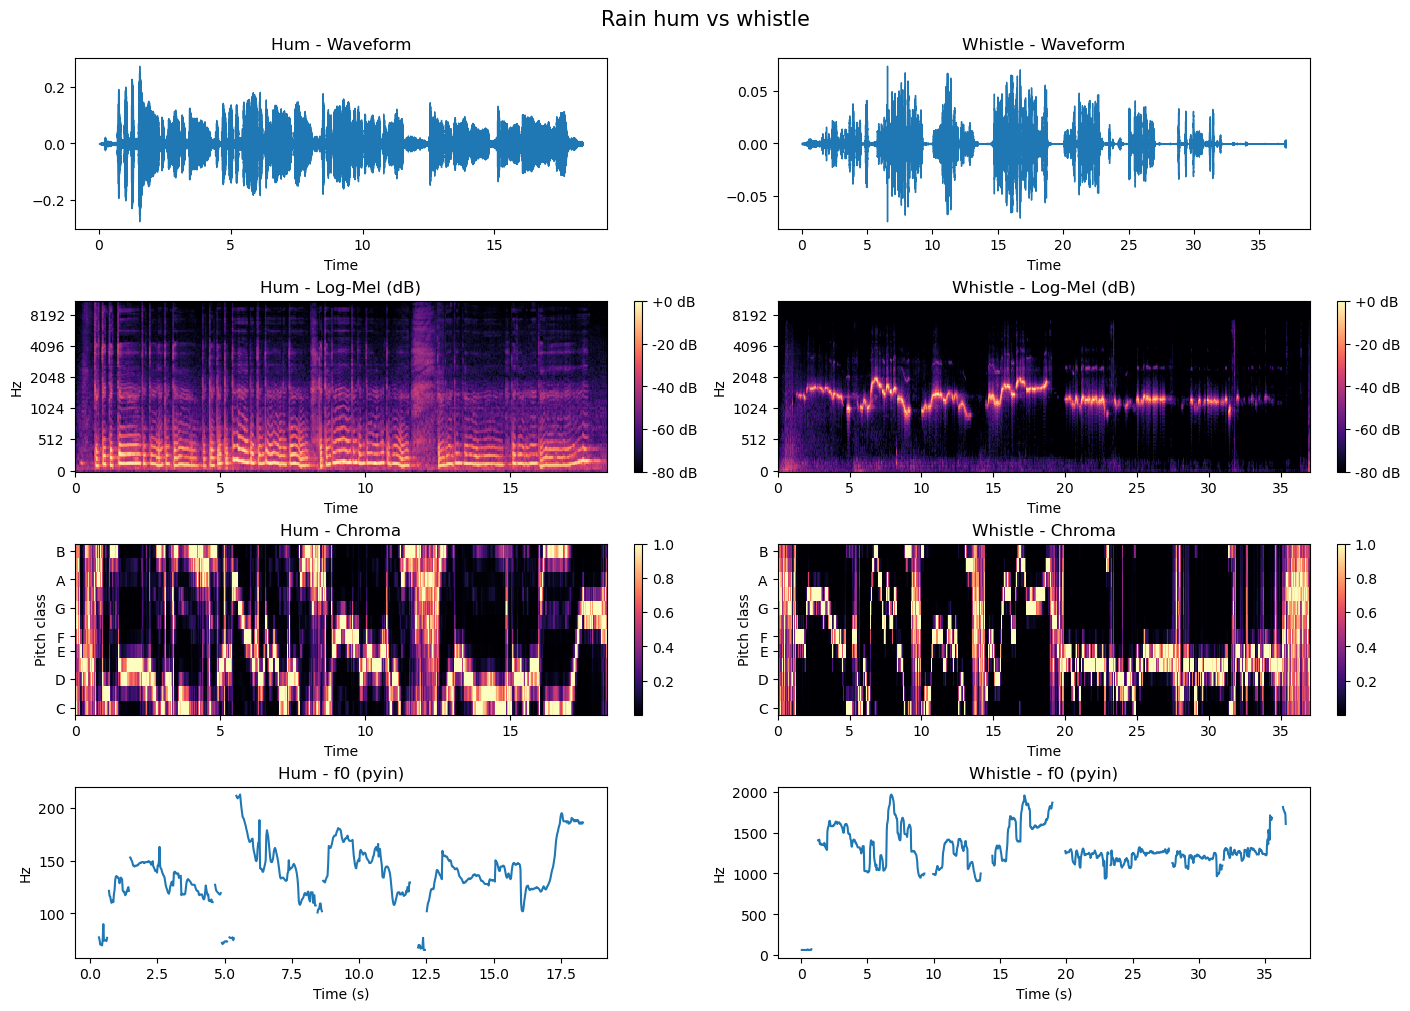

In [1]:
import os
import re
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# =========================
# 0) 配置：你的数据目录
# =========================
DATA_DIR = r"Data_MLEnd_Song\unzipped\MLEndHWII_sample_800"

# =========================
# 1) 解析文件名 -> 元数据表
# =========================
# 文件名示例：S1_hum_1_Rain.wav / S2_whistle_2_StarWars.wav
# 说明：S+数字=演唱者；hum/whistle=演绎方式；中间数字=take；最后=歌名
PATTERN = re.compile(r'^(S\d+)_(hum|whistle)_(\d+)_([A-Za-z0-9]+)\.wav$', re.IGNORECASE)

def build_meta_from_wav_dir(data_dir: str) -> pd.DataFrame:
    rows = []
    if not os.path.isdir(data_dir):
        raise ValueError(f"DATA_DIR 不存在或不是文件夹：{data_dir}")

    for fn in os.listdir(data_dir):
        if not fn.lower().endswith(".wav"):
            continue

        m = PATTERN.match(fn)
        if not m:
            # 如果有少数文件名不符合格式，直接跳过；你也可以print出来排查
            # print("Skip (name not match):", fn)
            continue

        singer, modality, take, song = m.group(1), m.group(2).lower(), int(m.group(3)), m.group(4)
        rows.append({
            "filename": fn,
            "filepath": os.path.join(data_dir, fn),
            "singer": singer,
            "type": modality,     # hum / whistle
            "take": take,
            "song": song
        })

    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError("没有解析到任何 wav 文件。请检查 DATA_DIR 或文件名格式是否符合 Sx_hum|whistle_take_song.wav")

    return df

# =========================
# 2) 找「同一首歌」的 hum ↔ whistle 配对（不要求同一人）
# =========================
def get_pairs_same_song(df_meta: pd.DataFrame, pick="min_take", random_state=42) -> pd.DataFrame:
    """
    pick:
      - "min_take": hum/whistle 各取 take 最小的一条（稳定可复现）
      - "random":   hum/whistle 各随机取一条（更贴近“总体差异”）
    """
    pairs = []

    for song in sorted(df_meta["song"].unique()):
        hums = df_meta[(df_meta["song"] == song) & (df_meta["type"] == "hum")]
        whistles = df_meta[(df_meta["song"] == song) & (df_meta["type"] == "whistle")]

        if len(hums) == 0 or len(whistles) == 0:
            continue

        if pick == "random":
            hum = hums.sample(1, random_state=random_state).iloc[0]
            whistle = whistles.sample(1, random_state=random_state).iloc[0]
        else:
            hum = hums.sort_values("take").iloc[0]
            whistle = whistles.sort_values("take").iloc[0]

        pairs.append({
            "song": song,
            "hum_file": hum["filepath"],
            "whistle_file": whistle["filepath"],
            "hum_singer": hum["singer"],
            "whistle_singer": whistle["singer"],
            "hum_take": hum["take"],
            "whistle_take": whistle["take"]
        })

    pairs_df = pd.DataFrame(pairs)
    if pairs_df.empty:
        raise ValueError("找不到同一首歌同时存在 hum 和 whistle 的配对样本。")

    return pairs_df

# =========================
# 3) 整段音频特征提取（不切片）
# =========================
def compute_features_full(y, sr, n_mels=128, n_fft=2048, hop_length=512):
    # Log-Mel
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels,
        n_fft=n_fft, hop_length=hop_length, power=2.0
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Chroma
    chroma = librosa.feature.chroma_stft(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
    )

    # f0（基频轨迹）：pyin 较稳，但会慢一点
    f0, _, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7"),
        sr=sr,
        hop_length=hop_length
    )

    return mel_db, chroma, f0

# =========================
# 4) 可视化：同一首歌 hum vs whistle
# =========================
def plot_modality_comparison_same_song(
    hum_path, whistle_path, title,
    sr=22050, n_mels=128, n_fft=2048, hop_length=512,
    show_f0=True,
    max_seconds=None
):
    """
    max_seconds：仅用于“可视化截断”，不是切片训练
      - None: 整段都画
      - 例如 20: 只画前 20 秒（图更清晰）
    """
    def load_audio(path):
        if max_seconds is None:
            y, _ = librosa.load(path, sr=sr)
        else:
            y, _ = librosa.load(path, sr=sr, duration=max_seconds)
        return y

    y_h = load_audio(hum_path)
    y_w = load_audio(whistle_path)

    mel_h, chr_h, f0_h = compute_features_full(y_h, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_w, chr_w, f0_w = compute_features_full(y_w, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)

    rows = 4 if show_f0 else 3
    fig, axes = plt.subplots(rows, 2, figsize=(14, 10), constrained_layout=True)
    fig.suptitle(title, fontsize=15)

    # Row 1: Waveform
    librosa.display.waveshow(y_h, sr=sr, ax=axes[0, 0])
    axes[0, 0].set_title("Hum - Waveform")
    librosa.display.waveshow(y_w, sr=sr, ax=axes[0, 1])
    axes[0, 1].set_title("Whistle - Waveform")

    # Row 2: Log-Mel
    img1 = librosa.display.specshow(mel_h, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", ax=axes[1, 0])
    axes[1, 0].set_title("Hum - Log-Mel (dB)")
    fig.colorbar(img1, ax=axes[1, 0], format="%+2.0f dB")

    img2 = librosa.display.specshow(mel_w, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", ax=axes[1, 1])
    axes[1, 1].set_title("Whistle - Log-Mel (dB)")
    fig.colorbar(img2, ax=axes[1, 1], format="%+2.0f dB")

    # Row 3: Chroma
    img3 = librosa.display.specshow(chr_h, sr=sr, hop_length=hop_length, x_axis="time", y_axis="chroma", ax=axes[2, 0])
    axes[2, 0].set_title("Hum - Chroma")
    fig.colorbar(img3, ax=axes[2, 0])

    img4 = librosa.display.specshow(chr_w, sr=sr, hop_length=hop_length, x_axis="time", y_axis="chroma", ax=axes[2, 1])
    axes[2, 1].set_title("Whistle - Chroma")
    fig.colorbar(img4, ax=axes[2, 1])

    # Row 4: f0
    if show_f0:
        t_h = librosa.times_like(f0_h, sr=sr, hop_length=hop_length)
        t_w = librosa.times_like(f0_w, sr=sr, hop_length=hop_length)

        axes[3, 0].plot(t_h, f0_h)
        axes[3, 0].set_title("Hum - f0 (pyin)")
        axes[3, 0].set_xlabel("Time (s)")
        axes[3, 0].set_ylabel("Hz")

        axes[3, 1].plot(t_w, f0_w)
        axes[3, 1].set_title("Whistle - f0 (pyin)")
        axes[3, 1].set_xlabel("Time (s)")
        axes[3, 1].set_ylabel("Hz")

    plt.show()

# =========================
# 5) 一键运行：列出可对比歌曲 & 画一组对比图
# =========================
df_meta = build_meta_from_wav_dir(DATA_DIR)
pairs = get_pairs_same_song(df_meta, pick="min_take")  # 或者 pick="random"

print("✅ 可用于『同一首歌』Hum vs Whistle 对比的样本对：")
display(pairs)

# 默认画第一首歌；你也可以改成 pairs[pairs['song']=="Rain"].iloc[0]
row0 = pairs.iloc[0]
title = (
    f"Modality Comparison (Same Song): {row0['song']}\n"
    f"Hum({row0['hum_singer']}, take={row0['hum_take']}) vs "
    f"Whistle({row0['whistle_singer']}, take={row0['whistle_take']})"
)

plot_modality_comparison_same_song(
    row0["hum_file"],
    row0["whistle_file"],
    title=title,
    sr=22050,
    n_mels=128,
    n_fft=2048,
    hop_length=512,
    show_f0=True,
    max_seconds=None  # 如果图太长可改成 20，只截取显示前 20 秒
)
row = pairs[pairs["song"] == "Feeling"].iloc[0]
plot_modality_comparison_same_song(row["hum_file"], row["whistle_file"], title="Rain hum vs whistle")

## 5.4 Exploratory Data Analysis (探索性数据分析)
我们对同一首歌曲 *Feeling* 在两种不同演绎方式（哼唱与口哨）下的音频特征进行对比分析。尽管两段音频由不同演唱者完成，但歌曲内容保持一致，因此该对比主要用于分析演绎方式差异对特征表示的影响。

### 时域波形（Waveform）
哼唱波形幅度较大且能量分布密集，反映出气息、共振和辅音成分的影响；而口哨波形幅度较小但周期性更强。该结果表明时域波形对演绎方式高度敏感，但对歌曲内容区分能力有限。

### Log-Mel 频谱图
哼唱的 Log-Mel 频谱在低频和中频区域呈现出较为分散的能量分布，而口哨的能量主要集中在中高频区域，谱线更加清晰。这说明 Log-Mel 特征对音色差异较为敏感，单独使用时可能受到演绎方式变化的影响。

### Chroma 特征
尽管演绎方式不同，哼唱与口哨在 Chroma 特征上的 pitch class 分布具有较高一致性，能够有效反映歌曲的旋律和和声结构，显示出良好的跨演绎方式鲁棒性。

### 基频轨迹（f0）
哼唱与口哨在绝对基频范围上存在显著差异，但其基频随时间变化的趋势具有相似性，表明旋律信息主要体现在相对音高变化而非绝对频率值中。这也支持在模型训练中采用音高归一化及 pitch shift 数据增强策略。

### 小结
总体而言，Waveform 和 Log-Mel 特征更容易受到演绎方式影响，而 Chroma 及相对音高信息能够更稳定地保留歌曲旋律结构，为后续跨模态歌曲识别模型的设计提供了依据。

# 6 Experiments and results

In [2]:
import os
import urllib.request
import zipfile
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
# ================= 1. 配置与下载模块 =================
URL = "https://github.com/thekmannn/MLEndHW_QHM5703_Sample/raw/main/MLEndHWII_sample_800.zip"
BASE_DIR = "Data_MLEnd_Song"
ZIP_PATH = os.path.join(BASE_DIR, "dataset.zip")
EXTRACT_DIR = os.path.join(BASE_DIR, "unzipped")
SAVE_DIR = "Data_MLEnd_Song"

# 测试集目标：每首歌每种类型取多少个
TEST_SAMPLES_PER_TYPE = 10 

def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        total_size = int(dl_file.getheader('Content-Length', 0))
        block_size = 8192
        with open(save_path, 'wb') as out_file, tqdm(total=total_size, unit='B', unit_scale=True, desc="正在下载") as pbar:
            while True:
                data = dl_file.read(block_size)
                if not data: break
                out_file.write(data)
                pbar.update(len(data))

# 执行下载与解压
os.makedirs(os.path.dirname(ZIP_PATH), exist_ok=True)
if not os.path.exists(ZIP_PATH):
    print(f"⬇️ 开始下载数据...")
    download_url(URL, ZIP_PATH)
else:
    print(f"✅ 文件已存在，跳过下载。")

if not os.path.exists(EXTRACT_DIR):
    print("📦 正在解压...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
else:
    print("✅ 文件夹已解压。")

✅ 文件已存在，跳过下载。
✅ 文件夹已解压。


In [4]:
# ================= 2. 元数据解析模块 =================
def parse_metadata(data_dir):
    wav_files = glob.glob(os.path.join(data_dir, '**', '*.wav'), recursive=True)
    data = []
    print(f"🔍 正在扫描文件，共发现 {len(wav_files)} 个音频...")
    
    for file_path in wav_files:
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        if len(parts) >= 4:
            p_id = parts[0]
            p_type = parts[1] # 'hum' or 'whistle'
            song_name = "_".join(parts[3:]).split('.')[0]
            
            data.append({
                'filepath': file_path,
                'filename': filename,
                'participant': p_id,
                'type': p_type,
                'song': song_name,
                # 创建分层标签：确保 "歌名+类型" 的组合在后续处理中可识别
                'stratify_group': f"{song_name}_{p_type}"
            })
    return pd.DataFrame(data)

df_meta = parse_metadata(EXTRACT_DIR)

# ================= 3. 数据集划分核心逻辑 (方案 B: Test + Dev) =================
# 策略：
# 1. 测试集: 固定每类 10 个 (严谨评估)
# 2. 开发集: 剩余所有数据 (保存为 dev.csv，供后续动态 K-Fold 切分)

def prepare_dev_test_sets(df):
    print(f"\n⚙️ 正在构建数据集 (方案 B)...")
    print(f"   - 测试集目标: 每首歌 10 Hum + 10 Whistle")
    print(f"   - 开发集: 剩余所有数据 (将用于动态交叉验证)")
    
    test_indices = []
    unique_songs = df['song'].unique()
    
    # --- A. 抽取固定数量的测试集 ---
    for song in unique_songs:
        for p_type in ['hum', 'whistle']:
            # 找到这首歌、这种类型的所有样本索引
            candidates = df[(df['song'] == song) & (df['type'] == p_type)]
            
            # 随机抽样
            if len(candidates) >= TEST_SAMPLES_PER_TYPE:
                selected = candidates.sample(n=TEST_SAMPLES_PER_TYPE, random_state=42)
            else:
                print(f"⚠️ 警告: {song}_{p_type} 样本不足，全取。")
                selected = candidates
            
            test_indices.extend(selected.index.tolist())
            
    # 构建测试集 DataFrame
    df_test = df.loc[test_indices].copy()
    
    # 构建开发集 (Dev Set) = 总数据 - 测试集
    # 这部分数据将在训练循环中被动态切分为 Train/Val
    df_dev = df.drop(test_indices).copy()
    
    return df_dev, df_test

# 执行划分
df_dev, df_test = prepare_dev_test_sets(df_meta)

# ================= 4. 结果核对与保存 =================
print("\n" + "="*40)
print("📊 数据集划分详细报告 (方案 B)")
print("="*40)
total = len(df_meta)
print(f"总样本数: {total}")
print(f"开发集 (Dev)  : {len(df_dev)} ({len(df_dev)/total:.1%}) -> 保存为 dev_file_list.csv (后续用于 4-Fold CV)")
print(f"测试集 (Test) : {len(df_test)} ({len(df_test)/total:.1%}) -> 保存为 test_file_list.csv (最终评估)")

print("\n[测试集 - 详细分布] (目标: 每类 10 个):")
print(df_test.groupby(['song', 'type']).size().unstack(fill_value=0))

# 保存为 CSV
os.makedirs(SAVE_DIR, exist_ok=True)
df_dev.to_csv(os.path.join(SAVE_DIR, "dev_file_list.csv"), index=False)
df_test.to_csv(os.path.join(SAVE_DIR, "test_file_list.csv"), index=False)

print(f"\n✅ 文件列表已保存至 {SAVE_DIR} 目录：")
print(f"   - dev_file_list.csv (请在训练代码中读取此文件进行 K-Fold 切分)")
print(f"   - test_file_list.csv")

🔍 正在扫描文件，共发现 800 个音频...

⚙️ 正在构建数据集 (方案 B)...
   - 测试集目标: 每首歌 10 Hum + 10 Whistle
   - 开发集: 剩余所有数据 (将用于动态交叉验证)

📊 数据集划分详细报告 (方案 B)
总样本数: 800
开发集 (Dev)  : 640 (80.0%) -> 保存为 dev_file_list.csv (后续用于 4-Fold CV)
测试集 (Test) : 160 (20.0%) -> 保存为 test_file_list.csv (最终评估)

[测试集 - 详细分布] (目标: 每类 10 个):
type           hum  whistle
song                       
Feeling         10       10
Friend          10       10
Happy           10       10
Married         10       10
Necessities     10       10
NewYork         10       10
RememberMe      10       10
TryEverything   10       10

✅ 文件列表已保存至 Data_MLEnd_Song 目录：
   - dev_file_list.csv (请在训练代码中读取此文件进行 K-Fold 切分)
   - test_file_list.csv


In [5]:
import librosa
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

# ================= Global Configuration =================
CFG = {
    'SR': 22050,
    'DURATION': 5,         # 训练切片长度 5s
    'STRIDE': 4,           # 训练切片步长 4s
    'N_MELS': 128,
    'N_CHROMA': 12,
    'N_FFT': 2048,
    'HOP_LENGTH': 512,
    'TARGET_FRAMES': 216   # Time dimension
}

SAMPLES_PER_TRACK = CFG['SR'] * CFG['DURATION']
STRIDE_SAMPLES = CFG['SR'] * CFG['STRIDE']

# ================= 1. Feature Extraction Core =================
def compute_dual_features(y, sr):
    """提取 Log-Mel 和 Chroma 双流特征"""
    # A. Log-Mel Spectrogram
    melspec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=CFG['N_MELS'], n_fft=CFG['N_FFT'], hop_length=CFG['HOP_LENGTH']
    )
    melspec = librosa.power_to_db(melspec, ref=np.max)

    # B. Chroma Feature
    chroma = librosa.feature.chroma_stft(
        y=y, sr=sr, n_fft=CFG['N_FFT'], hop_length=CFG['HOP_LENGTH']
    )
    
    # C. Dimension Alignment
    target_w = CFG['TARGET_FRAMES']
    for feat in [melspec, chroma]: # Simple check, handle individually in production
        pass 
    
    # Crop/Pad Mel
    if melspec.shape[1] > target_w: melspec = melspec[:, :target_w]
    else: melspec = np.pad(melspec, ((0, 0), (0, target_w - melspec.shape[1])))
        
    # Crop/Pad Chroma
    if chroma.shape[1] > target_w: chroma = chroma[:, :target_w]
    else: chroma = np.pad(chroma, ((0, 0), (0, target_w - chroma.shape[1])))

    return melspec, chroma

# ================= 2. Augmentation & Batch Processing =================




def prep_input(X): return np.expand_dims(X, axis=-1)

# ================= 3. Load File Lists =================
# 加载之前保存的列表，准备进入训练阶段
df_dev = pd.read_csv("Data_MLEnd_Song/dev_file_list.csv")
df_test = pd.read_csv("Data_MLEnd_Song/test_file_list.csv")
print(f"✅ Ready for training: Dev Set ({len(df_dev)}), Test Set ({len(df_test)})")

✅ Ready for training: Dev Set (640), Test Set (160)


In [7]:
import librosa
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

# ================= 4.1.3 Dynamic Data Augmentation Implementation =================

def augment_audio_chunk(y_chunk, sr):
    """
    动态数据增强函数：生成原始切片的多个变体。
    对应策略：
    1. 原始切片 (Original)
    2. 音高偏移 (Pitch Shift): ±1, ±2 半音 -> 迫使模型学习相对旋律，解决跑调问题
    3. 噪声注入 (Noise Injection): 叠加高斯噪声 -> 提高对抗环境底噪的鲁棒性
    """
    augmented_samples = []
    
    # 1. 原始样本
    augmented_samples.append(y_chunk)
    
    # 2. 音高偏移 (Pitch Shifting)
    # librosa.effects.pitch_shift 保持时长不变，改变音高
    pitch_steps = [-2, -1, 1, 2]
    for step in pitch_steps:
        y_shifted = librosa.effects.pitch_shift(y_chunk, sr=sr, n_steps=step)
        augmented_samples.append(y_shifted)
    
    # 3. 噪声注入 (Noise Injection)
    # 添加微量高斯白噪声 (强度系数 0.005)
    noise = np.random.randn(len(y_chunk)) * 0.005
    y_noise = y_chunk + noise
    augmented_samples.append(y_noise)
    
    return augmented_samples



    # 4. 转换为 float32 节省内存并清理列表
    print("Converting to NumPy arrays...")
    X_mel = np.array(X_mel_list, dtype=np.float32)
    del X_mel_list
    gc.collect()
    
    X_chroma = np.array(X_chroma_list, dtype=np.float32)
    del X_chroma_list
    gc.collect()
    
    return X_mel, X_chroma, np.array(y_labels)

def prep_input(X): 
    """
    预处理辅助函数：
    为 CNN 输入增加 Channel 维度: (N, H, W) -> (N, H, W, 1)
    """
    return np.expand_dims(X, axis=-1)

Classes: ['Feeling', 'Friend', 'Happy', 'Married', 'Necessities', 'NewYork', 'RememberMe', 'TryEverything']

================ Fold 1/4 ================


Segments (Aug=False, stride=2s): 100%|███████████████████████████████████████████████| 160/160 [01:48<00:00,  1.47it/s]


Epoch 1/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.1796 - loss: 2.0494 - val_accuracy: 0.1914 - val_loss: 2.0463 - learning_rate: 0.0010
Epoch 3/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.2183 - loss: 1.9983 - val_accuracy: 0.2084 - val_loss: 2.0080 - learning_rate: 0.0010
Epoch 4/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.2553 - loss: 1.9347 - val_accuracy: 0.2090 - val_loss: 2.0569 - learning_rate: 0.0010
Epoch 5/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.2771 - loss: 1.8845 - val_accuracy: 0.2473 - val_loss: 1.9601 - learning_rate: 0.0010
Epoch 6/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.3020 - loss: 1.8401 - val_accuracy: 0.2023 - val_loss: 2.0570 - learning_rate: 0.0010
Epoch 7/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.3174 - loss: 1.8086 - val_accuracy: 0.2278 - val_loss: 2.1353 - learning_rate: 0.0010
Epoch 8/30
517/517 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.3359 - l

Segments (Aug=False, stride=2s): 100%|███████████████████████████████████████████████| 160/160 [01:48<00:00,  1.47it/s]


Epoch 1/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.1476 - loss: 2.1121 - val_accuracy: 0.1709 - val_loss: 2.0527 - learning_rate: 0.0010
Epoch 2/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.1833 - loss: 2.0470 - val_accuracy: 0.1514 - val_loss: 2.0605 - learning_rate: 0.0010
Epoch 3/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step - accuracy: 0.2647 - loss: 1.9111 - val_accuracy: 0.2350 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 6/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.2827 - loss: 1.8767 - val_accuracy: 0.2582 - val_loss: 1.8951 - learning_rate: 5.0000e-04
Epoch 7/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - accuracy: 0.2929 - loss: 1.8614 - val_accuracy: 0.2509 - val_loss: 1.8832 - learning_rate: 5.0000e-04
Epoch 8/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - accuracy: 0.2999 - loss: 1.8486 - val_accuracy: 0.2631 - val_loss: 1.8895 - learning_rate: 5.0000e-04
Epoch 9/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy

Segments (Aug=False, stride=2s): 100%|███████████████████████████████████████████████| 160/160 [01:42<00:00,  1.56it/s]


Epoch 1/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.1998 - loss: 2.0247 - val_accuracy: 0.2142 - val_loss: 1.9925 - learning_rate: 0.0010
Epoch 3/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.2312 - loss: 1.9771 - val_accuracy: 0.2312 - val_loss: 1.9433 - learning_rate: 0.0010
Epoch 4/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.2512 - loss: 1.9352 - val_accuracy: 0.2469 - val_loss: 1.9130 - learning_rate: 0.0010
Epoch 5/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.2711 - loss: 1.8979 - val_accuracy: 0.2198 - val_loss: 1.9625 - learning_rate: 0.0010
Epoch 6/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.2878 - loss: 1.8668 - val_accuracy: 0.2619 - val_loss: 1.8540 - learning_rate: 0.0010
Epoch 7/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.2983 - loss: 1.8382 - val_accuracy: 0.2714 - val_loss: 1.8336 - learning_rate: 0.0010
Epoch 8/30
522/522 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.3133 - l

Segments (Aug=False, stride=2s): 100%|███████████████████████████████████████████████| 160/160 [01:42<00:00,  1.56it/s]


Epoch 1/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.1554 - loss: 2.1772 - val_accuracy: 0.1412 - val_loss: 2.0729 - learning_rate: 0.0010
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.1932 - loss: 2.0262 - val_accuracy: 0.2198 - val_loss: 2.0174 - learning_rate: 0.0010
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - accuracy: 0.2246 - loss: 1.9722 - val_accuracy: 0.2339 - val_loss: 1.9850 - learning_rate: 0.0010
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.2676 - loss: 1.8918 - val_accuracy: 0.2351 - val_loss: 1.9577 - learning_rate: 0.0010
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.2770 - loss: 1.8726 - val_accuracy: 0.2390 - val_loss: 1.9261 - learning_rate: 0.0010
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.2907 - loss: 1.8534 - val_accuracy: 0.2377 - val_loss: 1.9863 - learning_rate: 0.0010
Epoch 9/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.2987 - l

,fold,segment_acc,vote_acc,n_train_files,n_val_files
0,1,0.298299,0.38125,480,160
1,2,0.299756,0.32500,480,160
2,3,0.328518,0.43125,480,160
3,4,0.292652,0.36250,480,160


Mean vote_acc: 0.37500000000000006

✅ 将绘制 vote_acc 最好的一折：Fold 3, vote_acc=0.4313


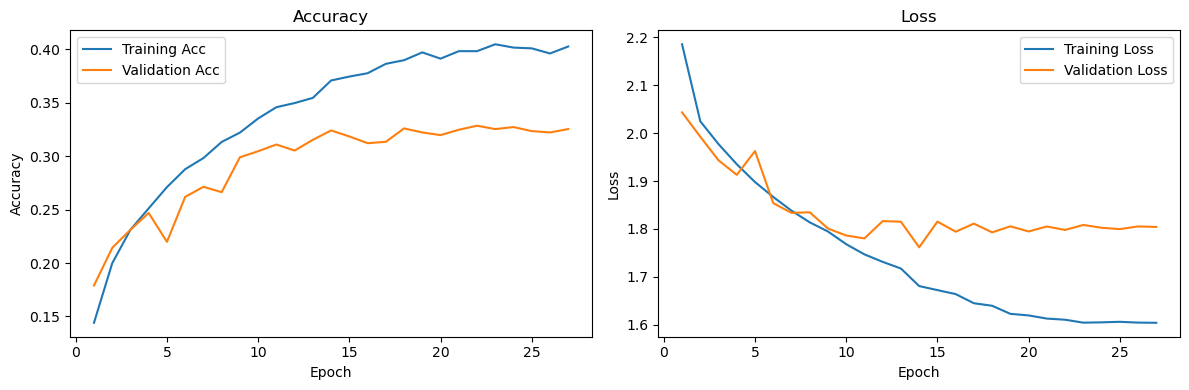


===== CV Aggregated Report (file-level voting) =====
               precision    recall  f1-score   support

      Feeling      0.338     0.287     0.311        80
       Friend      0.349     0.463     0.398        80
        Happy      0.477     0.512     0.494        80
      Married      0.474     0.225     0.305        80
  Necessities      0.336     0.500     0.402        80
      NewYork      0.355     0.138     0.198        80
   RememberMe      0.340     0.425     0.378        80
TryEverything      0.391     0.450     0.419        80

     accuracy                          0.375       640
    macro avg      0.382     0.375     0.363       640
 weighted avg      0.382     0.375     0.363       640


================ Final Training on ALL Dev ================


Segments (Aug=True, stride=4s): 100%|██████████████████████████████████████████████| 640/640 [1:10:10<00:00,  6.58s/it]


Epoch 1/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 59s 77ms/step - accuracy: 0.1465 - loss: 2.2265
Epoch 2/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.1856 - loss: 2.0427
Epoch 3/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.2222 - loss: 1.9856
Epoch 4/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.2402 - loss: 1.9559
Epoch 5/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.2535 - loss: 1.9314
Epoch 6/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.2654 - loss: 1.9081
Epoch 7/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.2819 - loss: 1.8840
Epoch 8/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - accuracy: 0.2897 - loss: 1.8623
Epoch 9/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.3072 - loss: 1.8305
Epoch 10/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - accuracy: 0.3152 - loss: 1.8120
Epoch 11/25
694/694 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.3254 - loss: 1.7932
Epoch 12/25
694/694 ━━━━━━━━━━

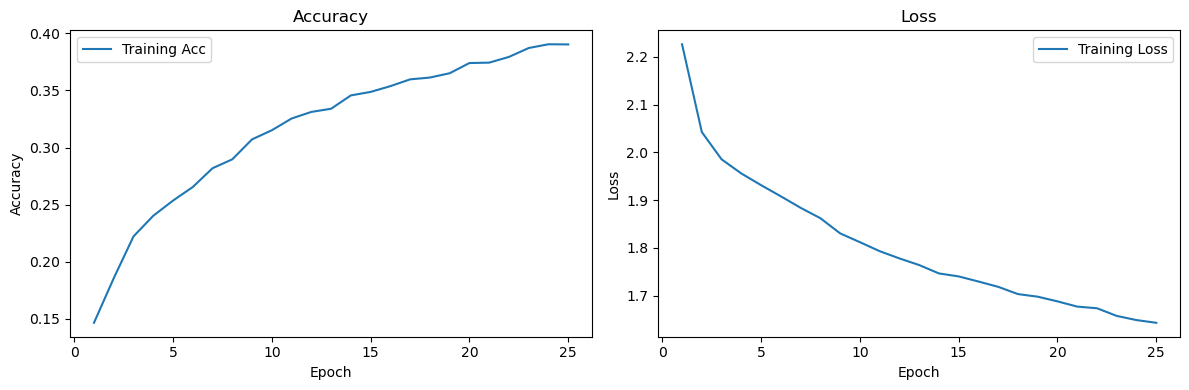

✅ model saved
✅ label classes saved


In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers



def plot_training_curves(history):
    """画 Accuracy / Loss 两张图"""
    hist = history.history
    acc_key = "accuracy" if "accuracy" in hist else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    if acc_key in hist: plt.plot(epochs, hist[acc_key], label="Training Acc")
    if val_acc_key in hist: plt.plot(epochs, hist[val_acc_key], label="Validation Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["loss"], label="Training Loss")
    if "val_loss" in hist: plt.plot(epochs, hist["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """画混淆矩阵并显示格子数字（不用 seaborn）"""
    cm = np.array(cm)
    fig = plt.figure(figsize=(9, 7))
    ax = plt.gca()

    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            ax.text(j, i, str(val),
                    ha="center", va="center",
                    color="white" if val > thresh else "black")

    plt.tight_layout()
    plt.show()

# ============================================================
# 6.1 修正版：process_dataset_dual_stream（增加 file_ids）
#     并允许传入 stride_seconds（训练/验证/测试可以不同）
# ============================================================
def process_dataset_dual_stream_with_ids(df, augment=False, stride_seconds=None):
    """
    文件级 -> 切片 ->（可选增强）-> 特征
    返回：
      X_mel:   (N, 128, 216)
      X_chr:   (N, 12, 216)
      y_labels:(N,)
      file_ids:(N,)  每个切片来自哪个原始音频（用于投票）
    """
    X_mel_list, X_chr_list, y_labels, file_ids = [], [], [], []

    sr = CFG['SR']
    samples_per_track = sr * CFG['DURATION']

    # stride 可覆盖全局 CFG，也可单独指定
    stride_s = CFG['STRIDE'] if stride_seconds is None else stride_seconds
    stride_samples = sr * stride_s

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Segments (Aug={augment}, stride={stride_s}s)"):
        fp = row['filepath']
        label = row['song']

        try:
            y_full, _ = librosa.load(fp, sr=sr)
        except Exception as e:
            print(f"❌ load fail: {fp} -> {e}")
            continue

        full_len = len(y_full)
        chunks = []

        # A: 太短补零
        if full_len < samples_per_track:
            y_pad = np.pad(y_full, (0, samples_per_track - full_len), mode='constant')
            chunks.append(y_pad)
        else:
            # B: 常规滑窗
            last_end = 0
            for start in range(0, full_len - samples_per_track + 1, stride_samples):
                end = start + samples_per_track
                chunks.append(y_full[start:end])
                last_end = end
            # C: back-tracking
            if last_end < full_len:
                chunks.append(y_full[-samples_per_track:])

        # 特征提取（含增强）
        for y_chunk in chunks:
            batch = augment_audio_chunk(y_chunk, sr) if augment else [y_chunk]
            for y_item in batch:
                mel, chr_ = compute_dual_features(y_item, sr)
                X_mel_list.append(mel)
                X_chr_list.append(chr_)
                y_labels.append(label)
                file_ids.append(fp)

    X_mel = np.array(X_mel_list, dtype=np.float32)
    X_chr = np.array(X_chr_list, dtype=np.float32)
    y_labels = np.array(y_labels)
    file_ids = np.array(file_ids)

    return X_mel, X_chr, y_labels, file_ids


def prep_input(X):
    # (N, H, W) -> (N, H, W, 1)
    return np.expand_dims(X, axis=-1)


# ============================================================
# 6.2 投票预测：整段音频（文件）级别预测
#     用“概率平均”投票更稳
# ============================================================
def predict_by_voting(model, X_mel, X_chr, file_ids, le: LabelEncoder, batch_size=64):
    probs = model.predict([X_mel, X_chr], batch_size=batch_size, verbose=0)  # (N, C)

    dfp = pd.DataFrame(probs)
    dfp["file_id"] = file_ids

    mean_probs = dfp.groupby("file_id").mean()  # (n_files, C)
    pred_idx = np.argmax(mean_probs.values, axis=1)
    pred_song = le.inverse_transform(pred_idx)

    return mean_probs.index.values, pred_song, mean_probs.values


# ============================================================
# 6.3 模型：Dual-stream CNN（适合你现在数据规模）
# ============================================================
def build_dual_cnn(num_classes: int):
    wd = 1e-4

    inp_mel = layers.Input(shape=(CFG['N_MELS'], CFG['TARGET_FRAMES'], 1), name="mel")
    x1 = layers.Conv2D(16, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(wd))(inp_mel)
    x1 = layers.MaxPool2D((2,2))(x1)
    x1 = layers.Conv2D(32, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(wd))(x1)
    x1 = layers.MaxPool2D((2,2))(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)

    inp_chr = layers.Input(shape=(CFG['N_CHROMA'], CFG['TARGET_FRAMES'], 1), name="chroma")
    x2 = layers.Conv2D(16, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(wd))(inp_chr)
    x2 = layers.MaxPool2D((2,2))(x2)
    x2 = layers.Conv2D(32, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(wd))(x2)
    x2 = layers.MaxPool2D((2,2))(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    x = layers.Concatenate()([x1, x2])
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model([inp_mel, inp_chr], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ============================================================
# 6.4 准备：LabelEncoder（只 fit 在 dev 上）
# ============================================================
le = LabelEncoder()
le.fit(df_dev["song"].values)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))


# ============================================================
# 6.5 4-fold Cross Validation（文件级 + 歌曲分层）
#     训练切片 stride 可用 4s（快），投票评估用 2s（稳）
# ============================================================
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

fold_rows = []
fold_histories = []
fold_vote_accs = []
all_true, all_pred = [], []

for fold, (tr_idx, va_idx) in enumerate(skf.split(df_dev, df_dev["song"]), start=1):
    print(f"\n================ Fold {fold}/4 ================")

    df_tr = df_dev.iloc[tr_idx].reset_index(drop=True)
    df_va = df_dev.iloc[va_idx].reset_index(drop=True)

    # 训练：增强=True（stride 用 CFG['STRIDE']，你现在是 4s）
    Xtr_mel, Xtr_chr, ytr_lbl, _ = process_dataset_dual_stream_with_ids(df_tr, augment=True, stride_seconds=CFG['STRIDE'])
    ytr = le.transform(ytr_lbl)

    # 验证：不增强 + stride=2（更多票更稳）
    Xva_mel, Xva_chr, yva_lbl_seg, va_file_ids = process_dataset_dual_stream_with_ids(df_va, augment=False, stride_seconds=2)
    yva_seg = le.transform(yva_lbl_seg)

    Xtr_mel, Xtr_chr = prep_input(Xtr_mel), prep_input(Xtr_chr)
    Xva_mel, Xva_chr = prep_input(Xva_mel), prep_input(Xva_chr)

    model = build_dual_cnn(num_classes)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]

    history = model.fit(
        [Xtr_mel, Xtr_chr], ytr,
        validation_data=([Xva_mel, Xva_chr], yva_seg),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # 记录这一折的曲线
    fold_histories.append(history)


    # --- Segment-level accuracy（可选写进报告）---
    seg_pred = np.argmax(model.predict([Xva_mel, Xva_chr], verbose=0), axis=1)
    seg_acc = accuracy_score(yva_seg, seg_pred)

    # --- File-level voting（核心指标）---
    va_files, va_pred_song, _ = predict_by_voting(model, Xva_mel, Xva_chr, va_file_ids, le)

    # 真值：按文件去 df_va 查
    true_map = dict(zip(df_va["filepath"].values, df_va["song"].values))
    va_true_song = np.array([true_map[f] for f in va_files])

    vote_acc = accuracy_score(va_true_song, va_pred_song)
    fold_vote_accs.append(vote_acc)

    print(f"[Fold {fold}] Segment Acc={seg_acc:.4f} | Voting Acc (file-level)={vote_acc:.4f}")

    fold_rows.append({"fold": fold, "segment_acc": seg_acc, "vote_acc": vote_acc,
                      "n_train_files": len(df_tr), "n_val_files": len(df_va)})

    all_true.extend(list(va_true_song))
    all_pred.extend(list(va_pred_song))

fold_df = pd.DataFrame(fold_rows)
print("\n===== 4-fold CV Summary =====")
display(fold_df)
print("Mean vote_acc:", fold_df["vote_acc"].mean())

best_i = int(np.argmax(fold_vote_accs))
print(f"\n✅ 将绘制 vote_acc 最好的一折：Fold {best_i+1}, vote_acc={fold_vote_accs[best_i]:.4f}")

plot_training_curves(fold_histories[best_i])

print("\n===== CV Aggregated Report (file-level voting) =====")
print(classification_report(all_true, all_pred, digits=3))


# ============================================================
# 6.6 Final model: train on ALL dev, test on test set (full-audio voting)
# ============================================================



print("\n================ Final Training on ALL Dev ================")
Xdev_mel, Xdev_chr, ydev_lbl, _ = process_dataset_dual_stream_with_ids(df_dev, augment=True, stride_seconds=CFG['STRIDE'])
ydev = le.transform(ydev_lbl)
Xdev_mel, Xdev_chr = prep_input(Xdev_mel), prep_input(Xdev_chr)

final_model = build_dual_cnn(num_classes)
history_final = final_model.fit(
    [Xdev_mel, Xdev_chr], ydev,
    epochs=25, batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3, restore_best_weights=True)],
    verbose=1
)


plot_training_curves(history_final)

os.makedirs("saved_models", exist_ok=True)
# 保存模型（结构+权重）
final_model.save("saved_models/dual_cnn_voting.keras")
print("✅ model saved")
np.save("saved_models/label_classes.npy", le.classes_)
print("✅ label classes saved")






================ Test Evaluation (full-audio voting) ================


Segments (Aug=False, stride=2s): 100%|███████████████████████████████████████████████| 160/160 [01:59<00:00,  1.34it/s]


[TEST] Voting Accuracy (file-level) = 0.4000

===== TEST Report (file-level voting) =====
               precision    recall  f1-score   support

      Feeling      0.333     0.200     0.250        20
       Friend      0.440     0.550     0.489        20
        Happy      0.500     0.500     0.500        20
      Married      0.533     0.400     0.457        20
  Necessities      0.389     0.350     0.368        20
      NewYork      0.421     0.400     0.410        20
   RememberMe      0.300     0.300     0.300        20
TryEverything      0.323     0.500     0.392        20

     accuracy                          0.400       160
    macro avg      0.405     0.400     0.396       160
 weighted avg      0.405     0.400     0.396       160

===== TEST Confusion Matrix (file-level voting) =====


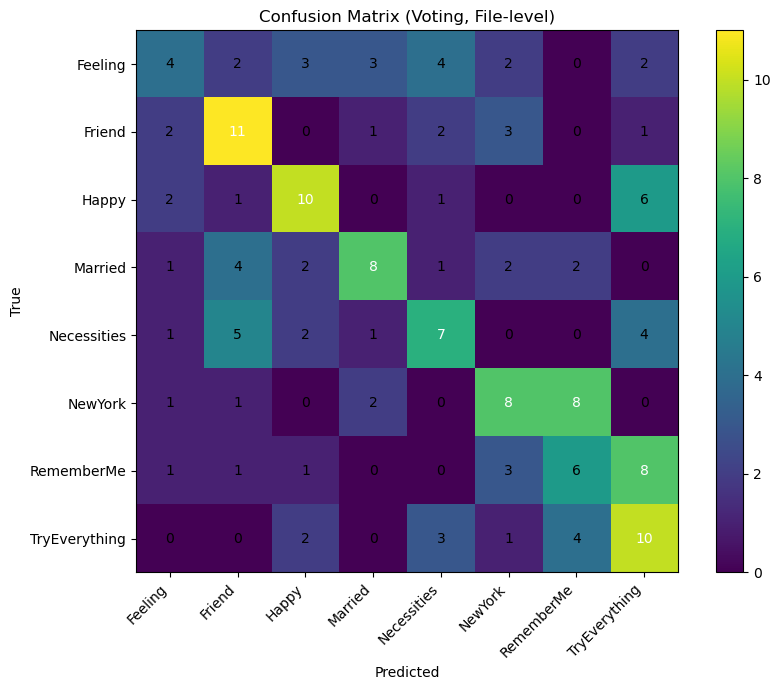

In [9]:
print("\n================ Test Evaluation (full-audio voting) ================")

# 1) 测试：不增强 + stride=2（投票更稳）
Xte_mel, Xte_chr, yte_lbl_seg, te_file_ids = process_dataset_dual_stream_with_ids(
    df_test, augment=False, stride_seconds=2
)
Xte_mel, Xte_chr = prep_input(Xte_mel), prep_input(Xte_chr)

# 2) 文件级投票预测
te_files, te_pred_song, _ = predict_by_voting(final_model, Xte_mel, Xte_chr, te_file_ids, le)

# 3) 文件级真实标签
true_map_test = dict(zip(df_test["filepath"].values, df_test["song"].values))
te_true_song = np.array([true_map_test[f] for f in te_files])

# 4) 指标
test_acc = accuracy_score(te_true_song, te_pred_song)
print(f"[TEST] Voting Accuracy (file-level) = {test_acc:.4f}\n")

print("===== TEST Report (file-level voting) =====")
print(classification_report(te_true_song, te_pred_song, digits=3))

# 5) 混淆矩阵（文件级投票）
print("===== TEST Confusion Matrix (file-level voting) =====")
cm = confusion_matrix(te_true_song, te_pred_song, labels=le.classes_)
plot_confusion_matrix(cm, list(le.classes_), title="Confusion Matrix (Voting, File-level)")


### 6.1 4-fold 交叉验证总体表现（File-level Voting）
本实验采用 **4-fold 交叉验证** 在 Dev 集上评估模型泛化能力，并使用 **“整段音频切片 → 模型预测概率 → 文件级平均投票”** 得到最终预测标签（file-level voting）。

从 CV Summary 可见：

- **Segment-level accuracy** 大约在 **0.29~0.33** 波动  
- **File-level voting accuracy** 大约在 **0.33~0.43** 波动  
- **平均 voting accuracy = 0.375**

这说明两点：

1. **投票确实有效**：文件级的 voting accuracy 明显高于 segment-level accuracy（例如 Fold3：segment≈0.329，而 voting≈0.431）。  
   - 原因是：单个 5s 切片可能只包含旋律片段、噪声、换气或发声不稳，容易误判；但整段音频有多个切片，平均概率相当于“集成”，能抵消不稳定切片的错误。
2. **折间波动较大**（0.325 到 0.431）：说明数据本身差异大（不同人、不同模态 hum/whistle、跑调、节奏不稳），模型对不同验证子集的适应性存在不确定性。

---

### 6.2 训练曲线分析（选择 vote_acc 最好的 Fold3 展示）
训练曲线（Accuracy / Loss）呈现出比较典型的现象：

- **训练准确率持续上升**（约从 0.15→0.40）
- **验证准确率上升后在 ~0.32 附近进入平台期**
- **训练 loss 持续下降**（到 ~1.60）
- **验证 loss 下降后趋于平稳甚至略抖动**（约稳定在 ~1.80 左右）

这一般表示：  
✅ 模型确实学到了一些模式（训练集越来越好）  
⚠️ 但泛化能力有限（验证集提升有限，出现“训练变好、验证不变”的 gap）

换句话说：**轻度过拟合 + 任务本身很难**。

可能原因包括：

- hum 和 whistle 的谱结构差异较大（whistle 更“单频主导”，hum 有更多泛音/共振/噪声），同一首歌在不同模态下特征差异明显；
- 歌曲之间旋律相似，短切片信息不足；
- 数据量对深度模型仍偏少（尤其有效信息 = “干净稳定的旋律段”更少）；
- 数据增强提升鲁棒性，但也可能引入部分与真实测试分布不一致的样本，使模型学习到非关键模式。

---

### 6.3 最终 Test 集结果（File-level Voting）
最终在 Test 集上使用 **stride=2s** 的切片投票（更密集、票更多），得到：

- **Test file-level voting accuracy = 0.400**
- **macro F1 ≈ 0.396**

该结果与 Dev 上平均 CV（0.375）接近，说明最终测试表现与交叉验证估计基本一致，整体可信。

---

### 6.4 分类报告（每类表现差异）
测试集 classification report（每类 support=20，类别均衡）显示：

- 表现相对更好的类别（更稳定）：
  - **Friend**：recall 0.55 / f1 0.489  
  - **Happy**：recall 0.50 / f1 0.500  
  - **Married / NewYork**：f1 在 0.41~0.46 左右  
- 表现较差的类别：
  - **Feeling**：recall 0.20 / f1 0.25（明显更难）
  - **RememberMe**：recall 0.30 / f1 0.30

解释：某些歌的旋律轮廓更“独特”，在 Log-Mel / Chroma 上更容易形成稳定模式；而另一些歌（例如 Feeling、RememberMe）可能旋律片段更像“通用流行旋律”，或 hum/whistle 表达差异更大，导致模型更难抓住区分点。

---

### 6.5 混淆矩阵分析（Voting, File-level）
混淆矩阵揭示了模型的主要错误并非随机，而是集中在少数类别对上：

1. **NewYork ↔ RememberMe 混淆明显**  
   - True NewYork 有 **8** 个被预测成 RememberMe，同时预测正确也是 **8** 个。  
   说明两者在模型看来特征非常相近（旋律走向、音高区间或模态表达可能高度重叠）。

2. **RememberMe → TryEverything 的误判突出**  
   - True RememberMe 被预测成 TryEverything **8** 次，而预测正确仅 **6** 次。  
   可能是 RememberMe 的旋律特征在短切片上更模糊，或哼唱/口哨时音准漂移导致 Chroma 结构不稳定。

3. **Happy 也会被预测成 TryEverything（6 次）**  
   - True Happy 预测成 TryEverything 6 次，而正确 10 次。  
   这表明 TryEverything 可能呈现“吸收型类别”的特征：模型在不确定时更倾向预测该类，或该类在训练中形成了更强的决策边界。

4. **Friend 相对更稳定**  
   - True Friend 预测正确 **11/20**，对角线较亮，说明该类的旋律/音色模式更一致、更容易学习。

总体而言，错误集中在少数“旋律结构相近/表达相近”的歌曲之间，说明主要瓶颈在于 **特征区分度不足** 与 **hum/whistle 模态差异造成的不稳定**。

---

### 6.6 小结
综合 CV 与 Test：

- 文件级投票能稳定提升性能（segment → file）。
- 最终 Test accuracy=0.40，macro F1≈0.396，与交叉验证预期一致。
- 主要问题来自若干类别对之间的强混淆（如 NewYork/RememberMe、RememberMe/TryEverything、Happy/TryEverything）。
- 训练集持续变好但验证提升有限，表明泛化瓶颈更多来自数据难度与特征表达，而不是训练流程本身。